# 1、卷积

## 前向过程

### Convolution概念

既然叫卷积神经网络，那么就先了解这里的卷积是什么，对于卷积神经网络一般使用离散数据，离散形式的函数$f,g$卷积定义如下：

$$(f*g)[n] = \sum_{m=-\infty}^{\infty} f[m]g[n-m]$$

而在卷积神经网络中使用的卷积则规定了卷积的范围不再是$[-\infty, \infty]$而是由被卷积数据size决定，假设有如下原始数据和卷积函数：

原始数据：
![](./data/image/conv1.jpg '原始数据')
卷积函数：
![](./data/image/conv2.jpg '卷积函数')
单点卷积结果（即对应位置相乘再求和）：
![](./data/image/conv3.jpg '单点卷积结果')
卷积结果：
![](./data/image/conv6.jpg '卷积结果')

根据卷积过程我们可知，设原始数据为$(m,n)$，卷积函数为$(f,f)$，卷积步长为$s$，那么得到的卷积结果为$(floor(\frac{m-f}{s}) + 1, floor(\frac{n-f}{s}) + 1)$。(**在深度学习中卷积矩阵基本为方阵**)

### Padding

可以看到卷积会所见数据尺寸，在卷积神经网络中我们有时需要数据尺寸不要减小太快，这时使用的手段就是“Padding”，通过在原始数据上增加padding数据来扩展数据然后再进行卷积计算。

进行“Padding”示意如下，使用元素“1”进行填充，填充尺寸$p=1$：

![](./data/image/padding.jpg 'Padding')

原本形状为$(m, n)$的数据进行尺寸为$p$的填充后形状为$(m+2p, n+2p)$。

### Valid&Same

有了“Padding”手段后我们可以先进行数据填充，然后在进行卷积运算，实际使用较多的为两种：

* Valid Convolution: 即不进行数据填充直接进行卷积运算
* Same Convolution: 首先以进行卷积后数据尺寸不变的目的进行填充，然后进行卷积运算


### 2D&3D

* 前面用来描述卷积概念的例子实际就是2D维度的卷积，一维卷积则更加简单，如最开始的数学描述，只是更改求和域。
* 3D维度的卷积则如下图所示，其中卷积函数与被卷积数据第三维度必须相同，卷积计算结果则需要进行3个维度的全部元素的求和。

![](./data/image/conv7.jpg 'Padding')

## 后向过程

### **$dA_{prev}：$**

这里的求解过程全部以前向过程引入了多少变化权重此处就需传播多少的角度来理解就直观很多，如下图计算卷积过程中每一个卷积窗与卷积核对应相乘后再相加得到一步卷积结果，那么卷积窗中元素变化能被传播到后层的大小即为卷积核对应位置的系数，所以在前向传播中我们只需要将$dZ$的每个元素与卷积核相乘放入卷积窗的位置最后得到即为前一层输入的后向传播结果$dA_{prev}$。

![](./data/image/conv8.jpg 'Padding')

$$z = \sum_{i=1}^{3} \sum_{j=1}^{3} x_{ij}w_{ij}$$

$$\frac{dz}{dx} = W$$

以上为一步卷积的前向传播推导，整个卷积其实就是重复这个过程，知道将全部卷积窗计算完成。

### **$dW：$**

根据前面的计算结果，可以得出

$$\frac{dz}{dW} = x$$

计算W的前向传播我们只需要将对应后一层误差的对应的卷积结果位置与卷积核的元素相乘放入对应位置即可。

### **$db：$**

$$\frac{dz}{db} = 1$$

由于在相对与一组数据和卷积核的计算过程中只使用一个标量的偏置，也就是所谓的“权值共享”,即将偏置广播倒每一个卷积结果中，那么求解$db$时其实就是将与$b$对应的卷积结果位置的误差求和。


# 2、Pooling

## 前向过程

单步"Pooling"操作如图所示是一个下采样过程，不同模式下以不同的规则对范围内特征进行采样，常用的有“Max”和“Mean”两种：

![](./data/image/pool1.jpg 'pool')

这里将原始数据的形状记为$(n_h, n_w, n_c)$，采样窗口的形状记为$(n_{fh}, n_{fw})$，$s$为采样步长，$n_c$表示数据深度（例如图片即可为其不同颜色通道），不同深度的采样单独进行，采样结束后的结果形状为$(\frac{n_h - n_{fh}}{s} + 1, \frac{n_w - n_{fw}}{s} + 1, n_c)$

## 后向过程

如前所述“Pooling”的前向过程为一个采样操作，那么后向过程我们来计算这个采样过程引入的误差：

![](./data/image/pool2.jpg 'pool backward')

* Max
  根据前向过程，我们只取了采样窗中的最大值作为采样结果，那么在后向传播误差的过程中也就只有采样位置的最大值起到了作用，所以其他部分填0，采样结果位置填最大值，即为传播因子。
 
* Mean
  根据前向过程，我们只取了采样窗中的全部样本均值作为采样结果，那么在后向传播误差的过程中每个位置起到的作用也就是采样结果对采样窗口的尺寸求平均，所以采样窗口位置填前向结果与采样窗口尺寸的比值。


# 3、FC

“full-conection”的存在其实就是为了将多维数据转换为单维数据，然后进行标签化等等操作，具体过程如下,对应到代码就是numpy中的flatten操作：

![](./data/image/fc1.jpg 'pool')

FC层只将数据进行了变形，而未引入任何有效误差，所以求解这一步的反向过程只需将后一层的误差根据原始数据的形状进行排列即可。


# 4、softmax

这是直接给出softmax的表达式，至于为何使用softmax而不是直接对数据进行归一化的讨论话题很多不再赘述，一个比较明显的优势就在于指数形式更便于做计算优化。

$$y = softmax(x)$$
$$y_i = \frac{e^{x_i}}{\sum_{j=1}^{n} e^j}$$

这里同时给出softmax函数的求导结果，

$$\frac{dy}{dx} = \begin{bmatrix} \frac{dy_1}{dx_1} & \cdots & \frac{dy_1}{dx_n} \\ \vdots & \ddots & \vdots \\ \frac{dy_n}{dx_1} & \cdots & \frac{dy_n}{dx_n} \end{bmatrix}$$

设$s = \sum_{j=1}^{n} e^{x_j}$，则$y_i = \frac{e^{x_i}}{s}$, 

$$\frac{dy_i}{dx_j} = \frac{d}{dx_j} \frac{e^{x_i}}{s}$$
$$= \frac{d}{dx_j} \frac{e^{x_i}}{s}$$
$$= \frac{(e^{x_i})^{'}s - e^{x_i}s^{'}}{s^2}$$

当$i = j$时：

$$= \frac{(e^{x_i})s - e^{x_i}e^{x_i}}{s^2}$$
$$= \frac{e^{x_i}}{s} (1 - \frac{e^{x_i}}{s})$$

当$i \ne j$时：

$$= \frac{0 - e^{x_i}e^{x_j}}{s^2}$$
$$= -\frac{e^{x_i}}{s} \frac{e^{x_j}}{s}$$

$$\frac{dy}{dx} = \begin{bmatrix} y_1(1-y_1) & -y_1y_2 & \cdots & -y_1y_n \\ -y_2y_1 & y_2(1-y_2) & \cdots & -y_2y_n \\ \vdots & \vdots &\ddots & \vdots \\ -y_ny_1 & -y_ny_2 & \cdots & y_n(1-y_n) \end{bmatrix}$$

# 5、Loss

典型的卷积神经网络最后将问题归结为一个最大似然问题，网络计算得到的结果记作$\widehat{y}$，实际结果为$y$

$$loss = \frac{1}{m} \sum_{i=1}^{m} \widehat{y}^{i} log^{y^{i}}$$

In [2]:
import sys
import os

if not os.getcwd() in sys.path:
    sys.path.append("%s/.." % os.getcwd())

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from arsenal.data_process.load_data import DataLoader
from arsenal.data_process.plot_data import Ploter
from arsenal.optimizer.grad_descent import GradDescent
from arsenal.model.cnn import ConvolutionNeuralNetwork

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 测试初始化函数

In [17]:
from config.map import test_initialize_map

np.random.randn(1)

X = np.random.rand(10,20,20,3)
test_initialize_map['L0']['cache']['A'] = X

CNN = ConvolutionNeuralNetwork(test_initialize_map)

CNN.initialize(end=len(test_initialize_map.keys())-1, seed=1)

print(CNN.map['L1']['cache']['W'].shape)
print(CNN.map['L1']['cache']['b'].shape)
print(CNN.map['L2']['cache']['W'].shape)
print(CNN.map['L2']['cache']['b'].shape)
print(CNN.map['L1']['cache']['A'].shape)
print(CNN.map['L2']['cache']['A'].shape)

(2, 2, 3, 2)
(1, 1, 1, 2)
(2, 2, 2, 2)
(1, 1, 1, 2)
(10, 9, 9, 2)
(10, 3, 3, 2)


### 测试pad函数

X shape:  (4, 3, 3, 2)
X padded shape:  (4, 7, 7, 2)
X[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
X_pad[1,1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


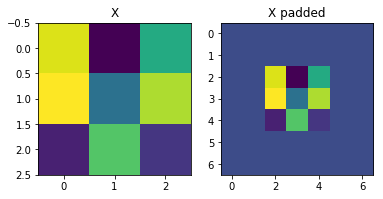

In [5]:
np.random.seed(1)
map = {}

CNN = ConvolutionNeuralNetwork(map)

X = np.random.randn(4,3,3,2)
X_pad = CNN.pad(X, n_pad=2, val=0)

print("X shape: ", X.shape)
print("X padded shape: ", X_pad.shape)
print ("X[1,1] =", X[1,1])
print ("X_pad[1,1] =", X_pad[1,1])

fig, axarr = plt.subplots(1,2)
axarr[0].set_title('X')
axarr[0].imshow(X[0, :, :, 0])
axarr[1].set_title('X padded')
axarr[1].imshow(X_pad[0, :, :, 0])
plt.show()

### 测试pool函数

In [6]:
np.random.seed(1)

map = {}

CNN = ConvolutionNeuralNetwork(map)

X = np.random.randn(2, 4, 4, 3)

stride = 2
f_shape = (3,3)

X_pool = CNN.pool_forward(X, f_shape, stride)
print("mode = max")
print("X_pool =", X_pool)
print()

X_pool = CNN.pool_forward(X, f_shape, stride, mode="average")
print("mode = average")
print("X_pool =", X_pool)

mode = max
X_pool = [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]

mode = average
X_pool = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## 测试convolution

In [7]:
np.random.seed(1)
map = {}
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
stride = 2
pad = 2
val = 0
CNN = ConvolutionNeuralNetwork(map)

Z = CNN.convolution_forward(A_prev, W, b, stride, pad, val)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])


# # Give A_prev 1 training example and 1 channel, so that
# # A_prev.shape = (1, n_H_prev, n_W_prev, 1)
# # n_H_prev and n_W_prev can be anything, 
# # as can any elements of A_prev
# n_H_prev = 5
# n_W_prev = 7
# A_prev = np.arange(n_H_prev*n_W_prev) + 1
# A_prev = A_prev.reshape((1, n_H_prev, n_W_prev, 1))

# # Make W a single 1-channel, 3x3 filter of all zeros,  
# # except for a 1 in the center
# W = np.zeros((3,3,1,1))
# W[1,1,0,0] = 1

# # Zero out b, with the appropriate dimensionality
# b = np.zeros((1,1,1,1))

# # Same padding: f = 3 ==> pad = (f-1)/2 = 1, stride = 1
# hparameters = {"pad":1, "stride":1}

# # Run conv_forward()
# Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

Z's mean = 0.0489952035289
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]


## 测试pool_backward函数

In [11]:
np.random.seed(1)

map = {}

CNN = ConvolutionNeuralNetwork(map)

A_prev = np.random.randn(5, 5, 3, 2)
stride = 1
f_shape = (2, 2)

dA = np.random.randn(5, 4, 2, 2)
#A = CNN.pool_forward(A_prev, f_shape, stride， mode='max')
dA_prev = CNN.pool_backward(dA, A_prev, f_shape, stride, mode='max')
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = CNN.pool_backward(dA, A_prev, f_shape, stride, mode='average')
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


## 测试convolution_backward函数

In [18]:
np.random.seed(1)

map = {}
CNN = ConvolutionNeuralNetwork(map)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
stride = 2
pad = 2
p_val = 0

Z = CNN.convolution_forward(A_prev, W, b, stride, pad, val)
#cache: A_prev, W, b, stride, pad,

dA, dW, db = CNN.convolution_backward(Z, A_prev, W, b, stride, pad, p_val)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.45243777754
dW_mean = 1.72699145831
db_mean = 7.83923256462
